# Week of 2025.04.28 

**Goals for the week:**
- [ ] Atmosphere integration 
    - [ ] It appears from my [work the previous week](https://paxtonsc.github.io/files/geophysics/volcano_project/2025.04.14.experiments.html) that so long as we run the atmosphere simulation with a solution order of `0` the number of timesteps does not need to be increased. Check with Eric and Mario to see if that is acceptable.
    - [ ] Generate synthetic infrasound data at the station locations and compare to recorded infrasound data. Mario ball park  expects 800 Pa.
- [ ] Debugging the low density eruption simulation
    - [x] Why is the density/speed of sound so low? Mario was setting the mass fraction of water as the porosity (incorrect).
    - [ ] Look into how to have the volume fraction of gas taken in as an initial condition? 
- [ ] Simple model for simulating parameters 
    - [ ] Review jump conditions + self similar rarefaction 
    - [ ] How can we create a simple model of the volcano eruption that accurately reflects the fragmentation front? 
- [ ] Get Mario's code for mapping pressure -> seismic behavior 

## 1.0 Generate synthetic infrasound data at the measuring stations

**Notes from Mario on how to handle the real infrasound data:**
- Band pass the infrasound data from 1 -> 20 Hz (use obspy)
- Mario has the factor of conversation (Mario to email it to Paxton) Mario will forward email with conversation factors. 
- We expect to see order 800 Pa
- Probably need the simulation to be 15 seconds. 

### 1.1 Review the updated eruption model

First, let's review the volcano eruption. Mario suggested some changes to the configuration file to reduce the low density in the plug we were seeing.

In [2]:
from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func
from helper_code.animate import animate_conduit_pressure

solver_func = get_local_solver_from_index_func("eruption_model", "tungurahua_rad_5_v22_conduit")
ani = animate_conduit_pressure(solver_func, iterations=150, viscosity_index=1, wall_friction_index=5, max_velocity=200, max_slip=150, max_tau=0.1, max_pressure=50, max_speed_of_sound=1000, max_water=2, max_density=5e3)

HTML(ani.to_html5_video())

**Notes on the eruption:**
- The pressure does not look very smooth? Is this what Mario expects? 
- The chamber pressure is much higher than it was previously, is this also nominal? 


### 1.2 Animate relative pressure over time

We subtract out the initial pressure in order to only look at relative pressure, which is the quantity we are interested in. 

In [23]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import processing.mdtools as mdtools

# Assume solver2D_from is available as in the original code
solver2D_from = get_local_solver_from_index_func("eruption_model", "test_infrasound_atm1")

# Set up figure
fig = plt.figure(figsize=(8, 6))

# Define pressure range for colormap
clims = (0.9e5, 1.01325e5)

# Initialize with first frame (index 0)
x, p = mdtools.downsample(solver2D_from(0), plot_qty="Pressure")
p0 = p.copy()  # Store initial pressure for reference
mdtools.plot_mean(x, p, clims)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap()
)
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")

# Animation update function
def update(frame):
    plt.cla()  # Clear current axis
    # Fetch data for current frame
    x, p = mdtools.downsample(solver2D_from(frame), plot_qty="Pressure")
    # Update plot
    mdtools.plot_mean(x, p, clims)
    plt.title(f"Pressure Field at Sec {round((15/100) * frame)}")
    return plt.gca(),

# Create animation
# Assume 100 frames for simulation; adjust based on solver data
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, 100, 1),  # Adjust range based on available solver indices
    interval=100,  # Time between frames in milliseconds
    blit=False
)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

TypeError: 'int' object is not subscriptable

Error in callback <function _draw_all_if_interactive at 0x108e50e00> (for post_execute), with arguments args (),kwargs {}:


TypeError: 'int' object is not subscriptable

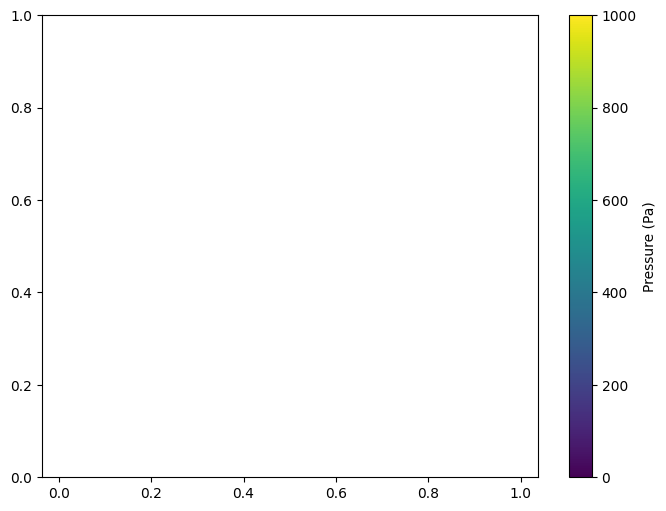

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import processing.mdtools as mdtools

# Assume solver2D_from is available as in the original code
solver2D_from = get_local_solver_from_index_func("eruption_model", "test_infrasound_atm1")

# Set up figure
fig = plt.figure(figsize=(8, 6))

# Define pressure range for colormap
clims = (0, 1e4)

# Initialize with first frame (index 0)
x, p = mdtools.downsample(solver2D_from(0), plot_qty="Pressure")
p0 = p.copy()  # Store initial pressure for reference
mdtools.plot_mean(x, p, clims)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=0, vmax=1e3),
    cmap=plt.get_cmap()
)
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")

# Animation update function
def update(frame):
    plt.cla()  # Clear current axis
    # Fetch data for current frame
    x, p = mdtools.downsample(solver2D_from(frame), plot_qty="Pressure")
    # Update plot
    mdtools.plot_mean(x, p-p0, clims)
    print(np.max(p - p0))
    plt.title(f"Pressure Field at Sec {round((15/100) * frame)}")
    return plt.gca(),

# Create animation
# Assume 100 frames for simulation; adjust based on solver data
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, 100, 1),  # Adjust range based on available solver indices
    interval=100,  # Time between frames in milliseconds
    blit=False
)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

In [25]:
np.max(p - p0)

np.float64(0.0)

**Notes on synthetic eruption data:**
- Pressure at sea level is like 100,000 Pa. 
- Mario said he expected ~800 Pa of pressure wave, is he talking about the pressure above the expected pressure from the atmosphere? 
- Are the diffusive affects in this simulation make the atmosphere model unhelpful? If we need to increase to the first order the simulation needs to 2 order of magnitude increase in steps. 

### 1.2 Plot observed infrasound data as a space time plot

The infrasound data can be found [here](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2017GL076419). 